Melihat distribusi total angka


In [ ]:
counts, bins = np.histogram(df['total_sum'], bins=20)

bin_centers = 0.5 * (bins[:-1] + bins[1:])



plt.figure(figsize=(10, 5)) 
plt.bar(bin_centers, counts, width=(bins[1]-bins[0])*0.9, color='steelblue', edgecolor='black', alpha=0.7)


mean_val = df['total_sum'].mean()
median_val = df['total_sum'].median()


plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='dotted', linewidth=2, label=f'Median: {median_val:.2f}')


# Tambahkan judul dan label
plt.title("Distribusi Total Angka (Bar Chart) dengan Garis Rata-rata dan Median")
plt.xlabel("Total Angka")
plt.ylabel("Frekuensi")
plt.legend()
plt.tight_layout()
plt.show()





for i in range(21):
    if(i == 20) :
        break
    print(f"Total Angka diantara {bins[i]}-{bins[i+1]} adalah {counts[i]}")

print(bin_centers)


NameError: name 'np' is not defined

In [ ]:
angka_terkecil = df['total_sum'].min()
angka_terbesar = df['total_sum'].max()
print(angka_terkecil , angka_terbesar)


27 247


Diagram Batang 
Frekuensi Kemunculan Tiap Angka

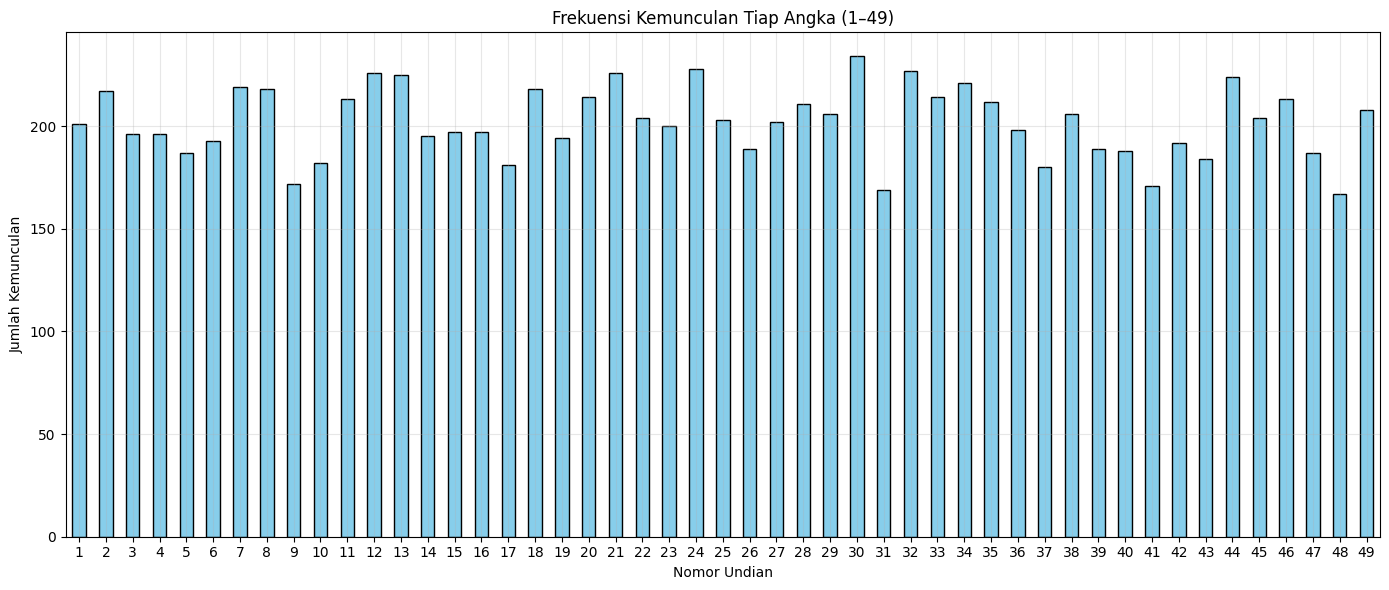

In [ ]:
# Ambil baris terakhir dari kolom b1_count sampai b49_count
freqs = df.iloc[-1, df.columns.get_loc('b1_count'):df.columns.get_loc('b49_count')+1]

# Buat grafik batang
plt.figure(figsize=(14, 6))
freqs.index = range(1, 50)  # ubah jadi 1–49
freqs.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Frekuensi Kemunculan Tiap Angka (1–49)")
plt.xlabel("Nomor Undian")
plt.ylabel("Jumlah Kemunculan")

plt.xticks(rotation=0)
plt.tight_layout()
plt.grid(alpha=0.3)
plt.show()


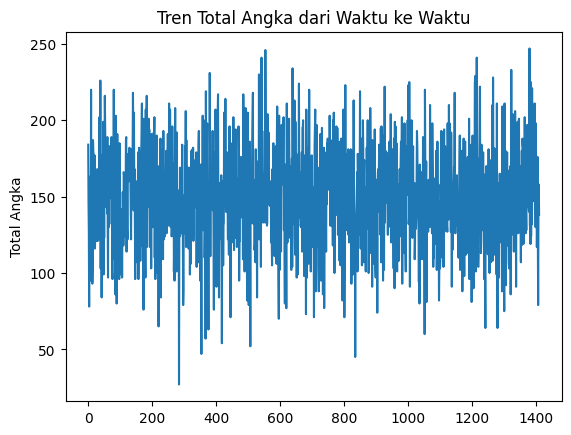

In [ ]:
df['total_sum'].plot(kind='line')
plt.title("Tren Total Angka dari Waktu ke Waktu")
plt.ylabel("Total Angka")
plt.show()

Hubungan Antar Fitur


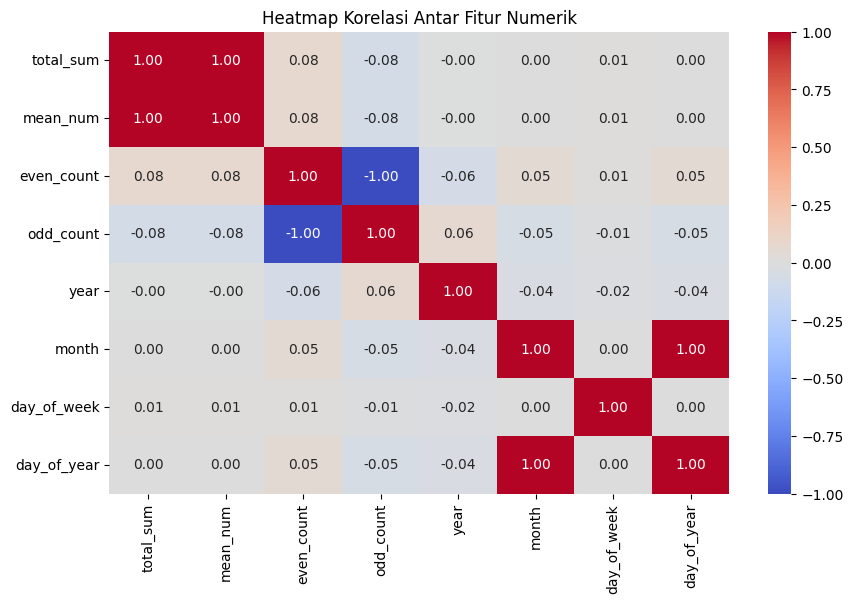

In [ ]:
numeric_cols = [
    'total_sum', 'mean_num', 'even_count', 'odd_count',
    'year', 'month', 'day_of_week', 'day_of_year'
]

# Buat matriks korelasi
corr = df[numeric_cols].corr()

# Visualisasi
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Korelasi Antar Fitur Numerik')
plt.show()

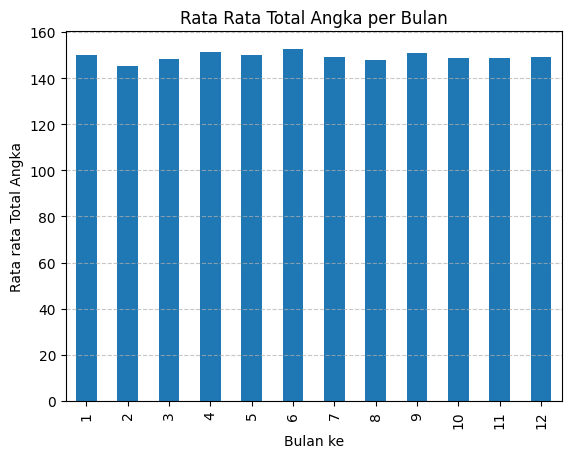

In [25]:
df.groupby('month')['total_sum'].mean().plot(kind='bar')
plt.title("Rata Rata Total Angka per Bulan")
plt.xlabel("Bulan ke")
plt.ylabel("Rata rata Total Angka")

plt.grid(axis='y', linestyle='--', alpha=0.7)

In [32]:
df.describe()

,special_num,num_1,num_2,num_3,num_4,num_5,num_6,num_7,num_8,num_9,...,b48_count,b49_count,total_sum,mean_num,even_count,odd_count,rolling_sum_mean,rolling_mean_diff,recent_even_ratio,recent_odd_ratio
count,1411.000000,1411.000000,1411.000000,1411.000000,1411.000000,1411.000000,1411.000000,1411.000000,1411.000000,1411.000000,...,1411.000000,1411.000000,1411.000000,1411.000000,1411.000000,1411.000000,1411.000000,1411.000000,1411.000000,1411.000000
mean,24.497519,0.142452,0.153792,0.138200,0.139617,0.131821,0.136782,0.155918,0.153083,0.121899,...,85.069454,104.068037,149.448618,24.908103,3.007796,2.992204,149.479802,-0.031184,0.501536,0.498464
std,14.287195,0.349637,0.360877,0.345232,0.346712,0.338416,0.343739,0.362906,0.360195,0.327286,...,46.678478,60.477166,32.890135,5.481689,1.160495,1.160495,14.416478,29.538397,0.086578,0.086578
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,27.000000,4.500000,0.000000,0.000000,104.200000,-93.800000,0.233333,0.166667
25%,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,49.000000,47.000000,128.000000,21.333333,2.000000,2.000000,139.600000,-20.700000,0.433333,0.433333
50%,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,84.000000,107.000000,151.000000,25.166667,3.000000,3.000000,149.600000,1.400000,0.500000,0.500000
75%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,123.000000,156.500000,172.000000,28.666667,4.000000,4.000000,159.600000,19.900000,0.566667,0.566667
max,49.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,167.000000,208.000000,247.000000,41.166667,6.000000,6.000000,188.600000,100.400000,0.833333,0.766667


Export to CSV

In [33]:
df.to_csv('lottery_hk(3).csv')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, hamming_loss, f1_score

# ============================================
# 1️⃣ Scraping data dari tahun 2015–2025
# ============================================

all_df = []

for i in range(2015, 2026):
    url = f'https://lottery.hk/en/mark-six/results/{i}'
    try:
        data = pd.read_html(url)[0]
        all_df.append(data)
        print(f"✅ Collected {data.shape[0]} rows for {i}")
    except Exception as e:
        print(f"❌ Error for {i}: {e}")

if all_df:
    df = pd.concat(all_df, ignore_index=True)
else:
    raise ValueError("Tidak ada data yang berhasil diambil!")

# ============================================
# 2️⃣ Pembersihan & Transformasi Data
# ============================================

df = df.rename(columns={"Draw Number": "draw_number", "Draw Date": "date", "Balls Drawn": "ball_draws"})
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')

# Hilangkan baris yang tidak valid
df = df[~df['ball_draws'].str.contains("January|February|March|April|May|June|July|August|September|October|November|December", case=False, na=False)]
df = df.drop(columns=["Detail", "draw_number"], errors="ignore")

# Pisahkan angka utama & angka spesial
split_cols = df['ball_draws'].str.split(expand=True)
df['special_num'] = split_cols.iloc[:, -1].astype(int)
df['ball_draws'] = split_cols.iloc[:, :-1].apply(lambda x: ' '.join(x.dropna()), axis=1)

df.sort_values(by='date', inplace=True)
df.reset_index(drop=True, inplace=True)

# ============================================
# 3️⃣ One-hot encoding untuk angka 1–49
# ============================================

mlb = MultiLabelBinarizer(classes=range(1, 50))
main_balls_list = df['ball_draws'].apply(lambda x: [int(n) for n in x.split()])
balls_encoded = mlb.fit_transform(main_balls_list)

balls_df = pd.DataFrame(balls_encoded, columns=[f'num_{i}' for i in range(1, 50)])
df = pd.concat([df, balls_df], axis=1)

# ============================================
# 4️⃣ Fitur Waktu dan Akumulasi
# ============================================

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_year'] = df['date'].dt.dayofyear

# Hitung jumlah kemunculan angka dari waktu ke waktu
y_array = mlb.fit_transform(main_balls_list)
y_binary = pd.DataFrame(y_array, columns=[f'b{i}_count' for i in range(1, 50)])

cumulative_counts = y_binary.cumsum()
shifted_counts = cumulative_counts.shift(1).fillna(0).astype(int)
df[[f'b{i}_count' for i in range(1, 50)]] = shifted_counts.values

# ============================================
# 5️⃣ Fitur Statistik
# ============================================

df['total_sum'] = main_balls_list.apply(sum)
df['mean_num'] = df['total_sum'] / 6
df['even_count'] = main_balls_list.apply(lambda x: sum(n % 2 == 0 for n in x))
df['odd_count'] = main_balls_list.apply(lambda x: sum(n % 2 != 0 for n in x))

# ============================================
# 6️⃣ Fitur Rolling (trend jangka pendek)
# ============================================

window = 5
df['rolling_sum_mean'] = df['total_sum'].rolling(window=window).mean()
df['rolling_mean_diff'] = df['total_sum'] - df['rolling_sum_mean']
df['recent_even_ratio'] = df['even_count'].rolling(window=window).mean() / 6
df['recent_odd_ratio'] = df['odd_count'].rolling(window=window).mean() / 6

# Hilangkan baris yang belum lengkap rolling-nya
df = df.dropna(subset=["rolling_sum_mean", "rolling_mean_diff", 
                       "recent_even_ratio", "recent_odd_ratio"]).reset_index(drop=True)



print("✅ Fitur tambahan berhasil dibuat!")



# --- 1️⃣ Pisahkan fitur dan target
fitur = ["even_count", "odd_count", "rolling_sum_mean", "rolling_mean_diff", "recent_even_ratio", "recent_odd_ratio"]
target = [f"num_{i}" for i in range(1, 50)]  # Target: num_1, num_2, ..., num_49

X = df[fitur]
y = df[target]  # y adalah setiap angka yang muncul dalam undian

# --- 2️⃣ Split data latih dan uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 3️⃣ Buat model MultiOutput Random Forest
model = MultiOutputClassifier(RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
))

# --- 4️⃣ Latih model
model.fit(X_train, y_train)

# --- 5️⃣ Prediksi di data uji
y_pred = model.predict(X_test)

# --- 6️⃣ Evaluasi
acc = accuracy_score(y_test, y_pred)
hloss = hamming_loss(y_test, y_pred)
f1_per_number = f1_score(y_test, y_pred, average=None)

print("=== Evaluasi Model ===")
print(f"Akurasi (semua angka benar): {acc:.4f}")
print(f"F1-Score per Angka : {f1_per_number.mean():.3f}")
print(f"Hamming Loss (rata-rata kesalahan per angka): {hloss:.4f}")


# --- 7️⃣ Prediksi undian baru (contoh: baris terakhir)
X_new = X.tail(1)
y_pred_new = model.predict(X_new)

# Ambil angka yang diprediksi muncul (bernilai 1)
predicted_numbers = [i+1 for i, v in enumerate(y_pred_new[0]) if v == 1]
print("\n=== Prediksi Angka Undian Berikutnya ===")
print(predicted_numbers)

# --- 8️⃣ (Opsional) Probabilitas tiap angka
proba = np.array([est.predict_proba(X_new)[:, 1] for est in model.estimators_]).T
proba = proba[0]
angka_dengan_prob = sorted(list(zip(range(1, 50), proba)), key=lambda x: x[1], reverse=True)
top6 = [num for num, p in angka_dengan_prob[:6]]

print("\nTop 6 angka dengan probabilitas tertinggi:")
print(top6)


✅ Collected 164 rows for 2015
✅ Collected 163 rows for 2016
✅ Collected 165 rows for 2017
✅ Collected 161 rows for 2018
✅ Collected 156 rows for 2019
✅ Collected 36 rows for 2020
✅ Collected 135 rows for 2021
✅ Collected 123 rows for 2022
✅ Collected 158 rows for 2023
✅ Collected 152 rows for 2024
✅ Collected 135 rows for 2025
✅ Fitur tambahan berhasil dibuat!
=== Evaluasi Model ===
Akurasi (semua angka benar): 0.0000
F1-Score per Angka : 0.069
Hamming Loss (rata-rata kesalahan per angka): 0.1380

=== Prediksi Angka Undian Berikutnya ===
[19, 26, 33, 35, 36, 39]

Top 6 angka dengan probabilitas tertinggi:
[36, 39, 35, 19, 33, 26]


In [3]:
df.to_csv('lottery_hk.csv')